In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
from os.path import getsize
from IPython.display import Audio
from random import choice

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/voice_data.csv")

smallest_file = min(df["filepath"], key=getsize)
y, sr = librosa.load(smallest_file)
y, _ = librosa.effects.trim(y)
duration = librosa.get_duration(y=y, sr=sr)
display(duration)

filepath = choice(df["filepath"])

3.960090702947846

In [3]:
y, sr = librosa.load(filepath)
y, _ = librosa.effects.trim(y)

# Cut audio to a common denominator
y = y[:int(sr*duration)]
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 171)

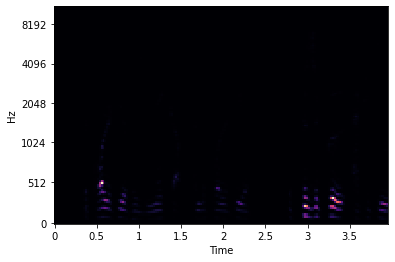

In [4]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [5]:
Audio(data=y, rate=sr)

In [6]:
df = pd.read_csv("../data/voice_data.csv")

filepath = choice(df["filepath"])
y, sr = librosa.load(filepath)
y, _ = librosa.effects.trim(y)

# Cut audio to a common denominator
y = y[:int(sr*duration)]
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 171)

In [7]:
def create_image(filepath):
    y, sr = librosa.load(filepath)
    # y, _ = librosa.effects.trim(y)
    y = y[:int(sr*duration)]
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    return ps

In [8]:
# df["ps"] = df["filepath"].map(create_image)
# df.to_pickle("../data/voice_data_image.pkl")

df = pd.read_pickle("../data/voice_data_image.pkl")

In [9]:
dataset = df[["speaker_id", "ps"]]

In [10]:
from PIL import Image
# Creates PIL image
img = Image.fromarray(np.uint8(dataset["ps"][0]), 'L')
img.show()

In [11]:
dataset["speaker_id"] = dataset["speaker_id"].str[2:].astype(int)
dataset

,speaker_id,ps
0,10000,"[[0.0051502828, 0.005539708, 0.013680633, 0.07..."
1,10000,"[[0.006160707, 0.0072584287, 0.06725639, 0.250..."
2,10000,"[[0.005288213, 0.0061552343, 0.009574708, 0.04..."
3,10000,"[[0.007232231, 0.007873862, 0.006506714, 0.053..."
4,10000,"[[0.0056619, 0.0067198602, 0.009038991, 0.0579..."
...,...,...
4408,11209,"[[0.0023705657, 0.0044698403, 0.0017119017, 0...."
4409,11209,"[[0.0018625895, 0.0026817555, 0.0010690652, 0...."
4410,11209,"[[0.004596038, 0.0027220503, 0.0025157814, 0.0..."
4411,11209,"[[0.009719292, 0.014528498, 0.011515867, 0.004..."


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[["ps"]], dataset[["speaker_id"]], test_size=0.25, shuffle=True, stratify=dataset[["speaker_id"]])

In [13]:
X_train = X_train["ps"].to_list()
X_test = X_test["ps"].to_list()
y_train = y_train["speaker_id"].to_list()
y_test = y_test["speaker_id"].to_list()

In [14]:
# X_train_2, y_train_2 = zip(*X_train_final)
# X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 171, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 171, 1) ) for x in X_test])

# One-Hot encoding for classes
# y_train = np.array(keras.utils.to_categorical(y_train))
# y_test = np.array(keras.utils.to_categorical(y_test))

In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.utils import to_categorical

code = np.array(y_train)
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(code)
y_train = to_categorical(vec)

vec = label_encoder.transform(y_test)
y_test = to_categorical(vec)

In [16]:
len(y_train[0])

26

In [17]:
len(y_test[0])

26

In [22]:
model = Sequential()
input_shape=(128, 171, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
# model.add(Dropout(rate=0.5))

model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
# model.add(Dropout(rate=0.5))

model.add(Dense(26))
model.add(Activation('softmax'))

In [ ]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train,
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])